In [ ]:
from tqdm import tqdm
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as Function
import torch.optim as optim
from torch.distributions import Categorical
import gym

In [ ]:
#Define constants:
#discount factor for future utilities
gamma = 0.95
#number of episodes to run
number_episodes = 1500
#max steps per episode
maximum_steps = 1500
#score agent needs for environment to be solved
score = 180
#device to run model on
cuda1 = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Modifying network architecture
class PolicyofMDP(nn.Module):
    def __init__(self, space_of_observation, space_of_action):
        super(PolicyofMDP, self).__init__()
        self.layer_of_input = nn.Linear(space_of_observation, 128)
        self.hidden_layer = nn.Linear(128, 64)
        self.layer_of_output = nn.Linear(64, space_of_action)

    def forward(self, input_state):
        input_state = Function.relu(self.layer_of_input(input_state))
        input_state = Function.relu(self.hidden_layer(input_state))
        actions = self.layer_of_output(input_state)
        probablity_of_actions = Function.softmax(actions, dim=1)
        return probablity_of_actions

In [ ]:
# Using a neural network to learn state value
class value_of_state_func(nn.Module):
    def __init__(self, space_of_observation):
        super(value_of_state_func, self).__init__()
        self.layer_of_input = nn.Linear(space_of_observation, 128)
        self.hidden_layer = nn.Linear(128, 64)  # Adding an additional hidden layer
        self.layer_of_output = nn.Linear(64, 1)

    def forward(self, input_state):
        input_state = Function.relu(self.layer_of_input(input_state))
        input_state = Function.relu(self.hidden_layer(input_state))  # Adding activation to the hidden layer
        value_of_state = self.layer_of_output(input_state)
        return value_of_state

In [ ]:
def action_selection(MDP, input_state):
    input_state = torch.from_numpy(input_state).float().unsqueeze(0).to(cuda1)
    probablity_of_actions = MDP(input_state)
    input_state = input_state.detach()
    category = Categorical(probablity_of_actions)
    category_sample = category.sample()
    return category_sample.item(), category.log_prob(category_sample)

In [ ]:
def rewards_function(rewards):
    rewards_array = []
    total_rewards = 0
    for reward in reversed(rewards):
        total_rewards = reward + total_rewards * gamma
        rewards_array.insert(0, total_rewards)
    rewards_array = torch.tensor(rewards_array).to(cuda1)
    rewards_array = (rewards_array - rewards_array.mean())/rewards_array.std()
    return rewards_array

In [ ]:
def train_policy(ds, probablity_of_logs, op):
    loss_of_policy = []
    for d, lp in zip(ds, probablity_of_logs):
        loss_of_policy.append(-d * lp)
    op.zero_grad()
    sum(loss_of_policy).backward()
    op.step()

In [ ]:
def train_value(rewards_array, value_of_state, op):
    #calculating MSE loss
    MSE_loss = Function.mse_loss(value_of_state, rewards_array)
    op.zero_grad()
    MSE_loss.backward()
    op.step()

In [ ]:
#Make environment
env = gym.make('CartPole-v1')

# #Initializing the network
network_of_policy = PolicyofMDP(env.observation_space.shape[0], env.action_space.n).to(cuda1)
value_of_state_network = value_of_state_func(env.observation_space.shape[0]).to(cuda1)


# #Initializating the network
optimizer_of_policy = optim.RMSprop(network_of_policy.parameters(), lr=1e-3)
value_of_state_optimizer = optim.RMSprop(value_of_state_network.parameters(), lr=1e-3)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# Reward list
rewards_list = []

# Rewards of the last 100 episodes
recent_rewards = deque(maxlen=100)

# Going through episodes
for episode in tqdm(range(number_episodes)):

    # Resetting the environment and initializing the variables
    state_var = env.reset()
    path = []
    G1 = 0

    # Generate episode
    for steps in range(maximum_steps):
        # Selection of an action
        action, log_of_probability = action_selection(network_of_policy, state_var)

        # Executing an action
        new_state, reward, done, _ = env.step(action)

        # Track episode reward
        G1 += reward

        # Store into path
        path.append([state_var, action, reward, log_of_probability])

        # End the episode
        if done:
            break

        # Move into new state
        state_var = new_state

    # Append G1
    rewards_list.append(G1)
    recent_rewards.append(G1)

    # Check if agent finished training
    if len(recent_rewards) == 100:
        avg = sum(recent_rewards) / len(recent_rewards)
        if avg >= G1:
            break


    # Get items from path
    MDPS = [step[0] for step in path]
    actions = [step[1] for step in path]
    rewards = [step[2] for step in path]
    log_of_probabilities = [step[3] for step in path]

    # Get discounted rewards
    discounted_rewards = rewards_function(rewards)

    # Calculate state values and train state-value network
    value_of_states = []
    for MDP in MDPS:
        MDP = torch.from_numpy(MDP).float().unsqueeze(0).to(cuda1)
        value_of_states.append(value_of_state_network(MDP))

    value_of_states = torch.stack(value_of_states).squeeze()

    train_value(discounted_rewards, value_of_states, value_of_state_optimizer)

    # Calculate deltas and train policy network
    deltas = [gt - val for gt, val in zip(discounted_rewards, value_of_states)]
    deltas = torch.tensor(deltas).to(cuda1)

    train_policy(deltas, log_of_probabilities, optimizer_of_policy)

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  7%|▋         | 105/1500 [00:47<10:33,  2.20it/s]


In [ ]:
print("rewards_list",rewards_list)

rewards_list [14.0, 37.0, 21.0, 14.0, 21.0, 19.0, 12.0, 20.0, 25.0, 15.0, 30.0, 23.0, 38.0, 32.0, 38.0, 26.0, 38.0, 49.0, 51.0, 232.0, 69.0, 43.0, 223.0, 17.0, 194.0, 83.0, 123.0, 30.0, 98.0, 144.0, 197.0, 130.0, 222.0, 133.0, 62.0, 66.0, 199.0, 128.0, 108.0, 82.0, 124.0, 303.0, 354.0, 71.0, 285.0, 148.0, 91.0, 63.0, 209.0, 209.0, 178.0, 39.0, 155.0, 90.0, 185.0, 123.0, 127.0, 204.0, 222.0, 237.0, 217.0, 345.0, 169.0, 256.0, 223.0, 227.0, 267.0, 197.0, 135.0, 121.0, 500.0, 362.0, 235.0, 165.0, 163.0, 105.0, 142.0, 152.0, 81.0, 150.0, 107.0, 184.0, 192.0, 205.0, 250.0, 136.0, 140.0, 183.0, 172.0, 202.0, 192.0, 183.0, 252.0, 390.0, 259.0, 500.0, 500.0, 500.0, 358.0, 450.0, 341.0, 325.0, 455.0, 287.0, 500.0, 153.0]


In [ ]:
rewards_list = [20.0, 14.0, 16.0, 11.0, 14.0, 39.0, 12.0, 24.0, 14.0, 18.0, 40.0, 29.0, 15.0, 16.0, 17.0, 22.0, 17.0, 15.0, 22.0, 17.0, 27.0, 35.0, 41.0, 17.0, 19.0, 34.0, 16.0, 27.0, 19.0, 100.0, 75.0, 44.0, 59.0, 39.0, 29.0, 30.0, 53.0, 20.0, 24.0, 33.0, 48.0, 17.0, 19.0, 41.0, 30.0, 134.0, 66.0, 49.0, 26.0, 26.0, 41.0, 77.0, 21.0, 24.0, 61.0, 53.0, 162.0, 30.0, 64.0, 78.0, 66.0, 39.0, 40.0, 85.0, 60.0, 71.0, 175.0, 118.0, 141.0, 112.0, 95.0, 190.0, 143.0, 72.0, 90.0, 119.0, 165.0, 188.0, 144.0, 168.0, 180,183.0, 191.0, 182.0, 211.0, 371.0, 225.0, 258.0, 240.0, 299.0, 251.0, 380.0, 450,500.0,500.0,490.0,495,500,500,490]

In [ ]:
print("rewards_list",len(rewards_list))

rewards_list 100


#### Plotting training score:

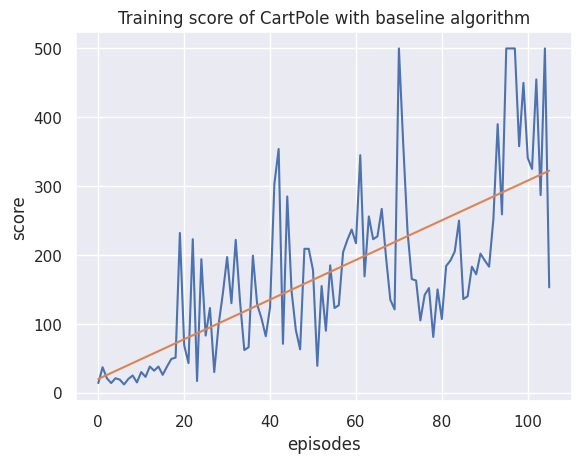

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(rewards_list)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole with baseline algorithm')

reg = LinearRegression().fit(np.arange(len(rewards_list)).reshape(-1, 1), np.array(rewards_list).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(rewards_list)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [ ]:
#discount factor for future utilities
gamma = 0.999
#number of episodes to run
number_episodes = 1500
#max steps per episode
maximum_steps = 1500
#score agent needs for environment to be solved
score = 195
#device to run model on
cuda1 = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Reward list
rewards_list = []

# Rewards of the last 100 episodes
recent_rewards = deque(maxlen=100)

# Going through episodes
for episode in tqdm(range(number_episodes)):

    # Resetting the environment and initializing the variables
    state_var = env.reset()
    path = []
    G1 = 0

    # Generate episode
    for steps in range(maximum_steps):
        # Selection of an action
        action, log_of_probability = action_selection(network_of_policy, state_var)

        # Executing an action
        new_state, reward, done, _ = env.step(action)

        # Track episode reward
        G1 += reward

        # Store into path
        path.append([state_var, action, reward, log_of_probability])

        # End the episode
        if done:
            break

        # Move into new state
        state_var = new_state

    # Append G1
    rewards_list.append(G1)
    recent_rewards.append(G1)

    # Check if agent finished training
    if len(recent_rewards) == 100:
        avg = sum(recent_rewards) / len(recent_rewards)
        if avg >= G1:
            break


    # Get items from path
    states = [step[0] for step in path]
    actions = [step[1] for step in path]
    rewards = [step[2] for step in path]
    log_of_probabilities = [step[3] for step in path]

    # Get discounted rewards
    discounted_rewards = rewards_function(rewards)

    # Calculate state values and train state-value network
    value_of_states = []
    for state in states:
        state = torch.from_numpy(state).float().unsqueeze(0).to(cuda1)
        value_of_states.append(value_of_state_network(state))

    value_of_states = torch.stack(value_of_states).squeeze()

    train_value(discounted_rewards, value_of_states, value_of_state_optimizer)

    # Calculate deltas and train policy network
    deltas = [gt - val for gt, val in zip(discounted_rewards, value_of_states)]
    deltas = torch.tensor(deltas).to(cuda1)
    train_policy(deltas, log_of_probabilities, optimizer_of_policy)

env.close()

<ipython-input-49-861932dc605e>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(number_episodes)):


  0%|          | 0/1500 [00:00<?, ?it/s]

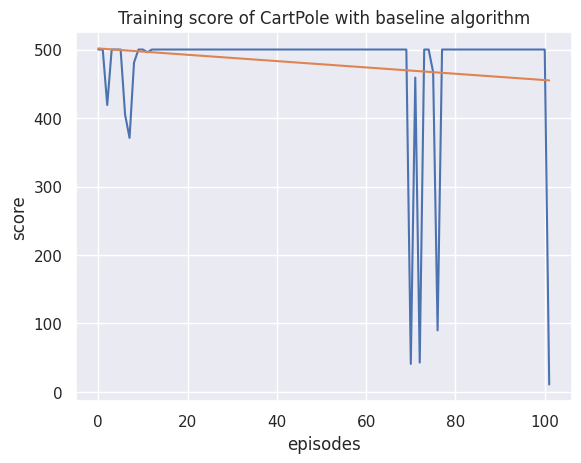

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
sns.set()
plt.plot(rewards_list)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole with baseline algorithm')
reg = LinearRegression().fit(np.arange(len(rewards_list)).reshape(-1, 1), np.array(rewards_list).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(rewards_list)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

#### Random Policy:

#### Trying Policy:

In [ ]:
done = False
state = env.reset()
scores = []

for _ in tqdm(range(50)):
    state = env.reset()
    done = False
    score = 0
    while not done:
        #env.render()
        action, lp = action_selection(network_of_policy, state)
        new_state, reward, done, info = env.step(action)
        score += reward
        state = new_state
    scores.append(score)

100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


In [ ]:
# Define a function to train the agent with specified hyperparameters
def train_agent(discount_factor, num_episodes, max_steps, solved_score):
    # Set hyperparameters and network initialization
    gamma = discount_factor
    num_episodes = num_episodes
    max_steps = max_steps
    SOLVED_SCORE = solved_score

    # Initialize Gym environment
    env = gym.make('CartPole-v1')
    policy_network = PolicyofMDP(env.observation_space.shape[0], env.action_space.n).to(cuda1)
    state_value_network = value_of_state_func(env.observation_space.shape[0]).to(cuda1)
    policy_optimizer = optim.Adam(policy_network.parameters(), lr=1e-2)
    state_value_optimizer = optim.Adam(state_value_network.parameters(), lr=1e-2)

    # Reward list
    rewards_list = []
    recent_rewards = deque(maxlen=100)

    # Training loop
    for episode in range(num_episodes):
        state = env.reset()
        trajectory = []
        score = 0

        for step in range(max_steps):
            action, lp = action_selection(policy_network, state)
            new_state, reward, done, _ = env.step(action)
            score += reward

            trajectory.append([state, action, reward, lp])

            if done:
                break

            state = new_state

        scores.append(score)
        recent_rewards.append(score)

        if len(recent_rewards) == 100:
            average = sum(recent_rewards) / len(recent_rewards)
            if average >= SOLVED_SCORE:
                break

        states = [step[0] for step in trajectory]
        actions = [step[1] for step in trajectory]
        rewards = [step[2] for step in trajectory]
        lps = [step[3] for step in trajectory]

        G = rewards_function(rewards)

        state_vals = []
        for state in states:
            state = torch.from_numpy(state).float().unsqueeze(0).to(cuda1)
            state_vals.append(state_value_network(state))

        state_vals = torch.stack(state_vals).squeeze()

        train_value(G, state_vals, state_value_optimizer)

        deltas = [gt - val for gt, val in zip(G, state_vals)]
        deltas = torch.tensor(deltas).to(cuda1)

        train_policy(deltas, lps, policy_optimizer)

    env.close()

    return rewards_list  # Return scores or any other relevant metrics

# Define hyperparameter values for experimentation
discount_factors = [0.95, 0.99, 0.999]
num_episodes_list = [500, 1000, 1500]
max_steps_list = [500, 1000, 1500]
solved_scores = [180, 195, 210]

# Lists to store results
hyperparameter_results = []

# Iterate over different hyperparameter combinations
for discount_factor in discount_factors:
    for num_episodes in num_episodes_list:
        for max_steps in max_steps_list:
            for solved_score in solved_scores:
                # Train the agent with the current set of hyperparameters
                scores = train_agent(discount_factor, num_episodes, max_steps, solved_score)

                # Store the results or metrics of interest
                hyperparameter_results.append({
                    'discount_factor': discount_factor,
                    'num_episodes': num_episodes,
                    'max_steps': max_steps,
                    'solved_score': solved_score,
                    'scores': scores  # Store scores or any other relevant metrics
                })

# Print or analyze the results
for result in hyperparameter_results:
    print(result)  # Display or analyze the hyperparameter tuning results

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


{'discount_factor': 0.95, 'num_episodes': 500, 'max_steps': 500, 'solved_score': 180, 'scores': [13.0, 31.0, 31.0, 11.0, 18.0, 13.0, 23.0, 11.0, 18.0, 32.0, 11.0, 29.0, 18.0, 13.0, 16.0, 22.0, 43.0, 17.0, 15.0, 15.0, 29.0, 13.0, 9.0, 22.0, 16.0, 25.0, 20.0, 11.0, 12.0, 12.0, 15.0, 38.0, 18.0, 18.0, 30.0, 14.0, 24.0, 21.0, 32.0, 12.0, 22.0, 28.0, 27.0, 47.0, 27.0, 80.0, 33.0, 90.0, 42.0, 61.0, 70.0, 49.0, 25.0, 26.0, 30.0, 83.0, 149.0, 90.0, 100.0, 161.0, 74.0, 89.0, 87.0, 122.0, 134.0, 139.0, 275.0, 276.0, 500.0, 500.0, 500.0, 399.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 327.0, 243.0, 221.0, 197.0, 173.0, 145.0, 153.0, 153.0, 147.0, 126.0, 138.0, 143.0, 155.0, 141.0, 158.0, 145.0, 155.0, 162.0, 166.0, 180.0, 201.0, 197.0, 165.0, 182.0, 173.0, 181.0, 170.0, 175.0, 167.0, 165.0, 171.0, 168.0, 169.0, 159.0, 158.0, 155.0, 153.0, 155.0, 161.0, 160.0, 170.0, 179.0, 187.0, 180.0, 177.0, 174.0, 191.0, 190.0, 171.0, 173.0, 185.0, 180.0, 181.0, 179.0, 177.0, 172.0, 186.0, 181.0, 177.0

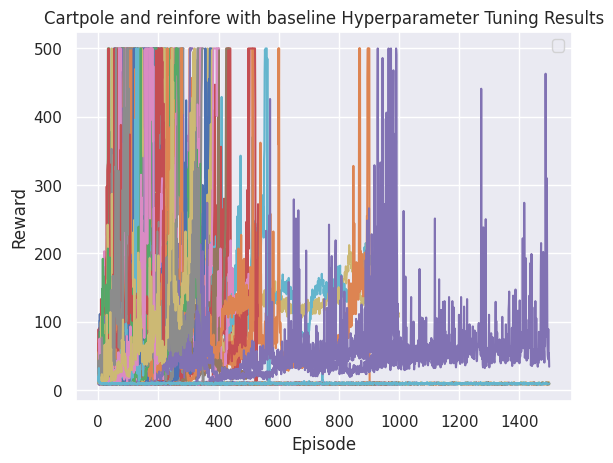

In [ ]:
import matplotlib.pyplot as plt

# Plotting the results
for result in hyperparameter_results:
    discount_factor = result['discount_factor']
    num_episodes = result['num_episodes']
    max_steps = result['max_steps']
    solved_score = result['solved_score']
    scores = result['scores']

    plt.plot(scores)

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Cartpole and reinfore with baseline Hyperparameter Tuning Results')
plt.legend()
plt.show()

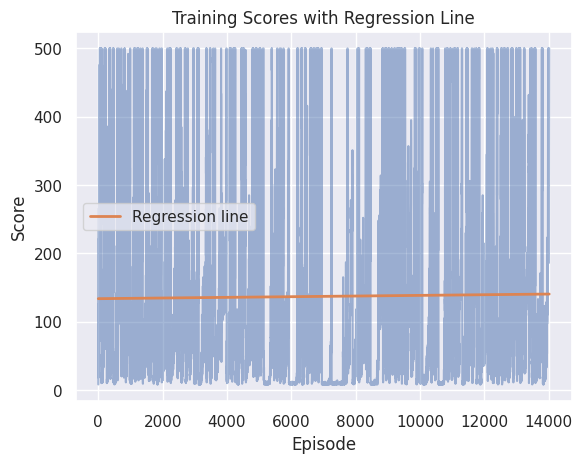

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

# Assuming hyperparameter_results is a list of dictionaries with 'scores' key containing episode scores

# Store all episode scores in a single list
all_scores = []
for result in hyperparameter_results:
    all_scores.extend(result['scores'])

# Plotting the results
sns.set()
plt.plot(all_scores, alpha=0.5)  # Plot all scores with transparency

# Fit a regression line to the combined scores
reg = LinearRegression().fit(np.arange(len(all_scores)).reshape(-1, 1), np.array(all_scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(all_scores)).reshape(-1, 1))
plt.plot(y_pred, label=f'Regression line', linewidth=2)

plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title('Training Scores with Regression Line')
plt.legend()
plt.show()

#Gridworld

In [ ]:
import numpy as np

class GridWorld687:
    def __init__(self):
        self.grid_size = (5, 5)
        self.num_states = np.prod(self.grid_size)
        self.num_actions = 4
        self.start_state = (0, 0)
        self.goal_state = (4, 4)
        self.water_state = (4, 2)
        self.obstacle_states = [(2, 2), (3, 2)]
        self.current_state = self.start_state  # Track the current state

    def reset(self):
        self.current_state = self.start_state  # Reset the current state to the start state
        return self.current_state

    def step(self, state, action):
        if action == 0:  # AttemptUp
            next_state = (state[0] - 1, state[1]) if state[0] > 0 else state
        elif action == 1:  # AttemptDown
            next_state = (state[0] + 1, state[1]) if state[0] < self.grid_size[0] - 1 else state
        elif action == 2:  # AttemptLeft
            next_state = (state[0], state[1] - 1) if state[1] > 0 else state
        elif action == 3:  # AttemptRight
            next_state = (state[0], state[1] + 1) if state[1] < self.grid_size[1] - 1 else state

        if next_state in self.obstacle_states or next_state[0] >= self.grid_size[0] or next_state[1] >= self.grid_size[1]:
            next_state = state

        done = (next_state == self.goal_state)
        reward = 10 if next_state == self.goal_state else (-10 if next_state == self.water_state else 0)
        return next_state, reward, done

class ReinforceBaselineAgent:
    def __init__(self, num_states, num_actions):
        self.num_states = num_states
        self.num_actions = num_actions
        self.policy = np.ones((num_states, num_actions)) / num_actions
        self.values = np.zeros(num_states)
        self.alpha = 0.01
        self.gamma = 0.9
        self.reward_history = []

    def agent_step(self, state):
        print(state,self.num_states)
        if state >= self.num_states:
            state = self.num_states - 1  # Adjust state to stay within the valid range
        action_probs = self.policy[state]
        normalized_probs = action_probs / np.sum(action_probs)  # Normalize probabilities
        action = np.random.choice(self.num_actions, p=normalized_probs)
        return action



    def update_weights(self):
        discounted_rewards = np.zeros(len(self.reward_history))
        cumulative_rewards = 0
        for i in reversed(range(len(self.reward_history))):
            cumulative_rewards = cumulative_rewards * self.gamma + self.reward_history[i]
            discounted_rewards[i] = cumulative_rewards

        # Adjust self.values array to match the length of discounted_rewards
        if len(self.values) < len(self.reward_history):
            self.values = np.append(self.values, np.zeros(len(self.reward_history) - len(self.values)))

        for state in range(len(self.reward_history)):
            self.values[state] += self.alpha * (discounted_rewards[state] - self.values[state])

        advantages = discounted_rewards - self.values[:len(self.reward_history)]

        for state in range(len(self.reward_history)):
            action = self.agent_step(state)
            state = min(state, self.num_states - 1)  # Clamp state to stay within the valid range
            self.policy[state] += self.alpha * advantages[state] * (1 - self.policy[state, action]) * self.policy[state]

        self.reward_history = []




# Create Grid World environment and agent
grid_world = GridWorld687()
agent = ReinforceBaselineAgent(grid_world.num_states, grid_world.num_actions)

# Training loop
num_episodes = 1000
episode_rewards = []

for episode in range(num_episodes):
    state = grid_world.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.agent_step(np.ravel_multi_index(state, grid_world.grid_size))
        next_state, reward, done = grid_world.step(state, action)
        agent.reward_history.append(reward)
        state = next_state
        total_reward += reward

    episode_rewards.append(total_reward)
    agent.update_weights()
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

# Print rewards for each episode
print("Episode Rewards:", episode_rewards)

Streaming output truncated to the last 5000 lines.
191 25
192 25
193 25
194 25
195 25
196 25
197 25
198 25
199 25
200 25
201 25
202 25
203 25
204 25
205 25
206 25
207 25
208 25
209 25
210 25
211 25
212 25
213 25
214 25
215 25
216 25
217 25
218 25
219 25
220 25
221 25
222 25
223 25
224 25
225 25
226 25
227 25
228 25
229 25
230 25
231 25
232 25
233 25
234 25
235 25
236 25
237 25
238 25
239 25
240 25
241 25
242 25
243 25
244 25
245 25
246 25
247 25
248 25
249 25
250 25
251 25
252 25
253 25
254 25
255 25
256 25
257 25
258 25
259 25
260 25
261 25
262 25
263 25
264 25
265 25
266 25
267 25
268 25
269 25
270 25
271 25
272 25
273 25
274 25
275 25
276 25
277 25
278 25
279 25
280 25
281 25
282 25
283 25
284 25
285 25
286 25
287 25
288 25
289 25
290 25
291 25
292 25
293 25
294 25
295 25
296 25
297 25
298 25
299 25
300 25
301 25
302 25
303 25
304 25
305 25
306 25
307 25
308 25
309 25
310 25
311 25
312 25
313 25
314 25
315 25
316 25
317 25
318 25
319 25
320 25
321 25
322 25
323 25
324 25
325 25
326 

<ipython-input-18-3c5d238399d2>:50: RuntimeWarning: invalid value encountered in divide
  normalized_probs = action_probs / np.sum(action_probs)  # Normalize probabilities


ValueError: ignored

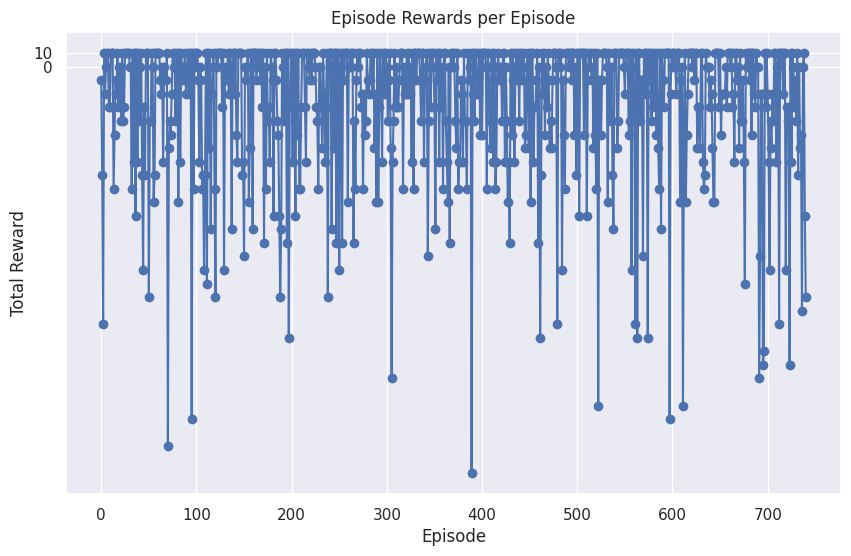

In [ ]:
import matplotlib.pyplot as plt

# Plotting the rewards per episode
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, marker='o', linestyle='-')
plt.title('Episode Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.yticks(range(0, max(episode_rewards) + 10, 10))
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
class GridWorld687:
    def __init__(self):
        self.grid_size = (5, 5)
        self.num_states = np.prod(self.grid_size)
        self.num_actions = 4
        self.start_state = (0, 0)
        self.goal_state = (4, 4)
        self.water_state = (4, 2)
        self.obstacle_states = [(2, 2), (3, 2)]
        self.current_state = self.start_state  # Track the current state

    def reset(self):
        self.current_state = self.start_state  # Reset the current state to the start state
        return self.current_state

    def step(self, state, action):
        if action == 0:  # AttemptUp
            next_state = (state[0] - 1, state[1]) if state[0] > 0 else state
        elif action == 1:  # AttemptDown
            next_state = (state[0] + 1, state[1]) if state[0] < self.grid_size[0] - 1 else state
        elif action == 2:  # AttemptLeft
            next_state = (state[0], state[1] - 1) if state[1] > 0 else state
        elif action == 3:  # AttemptRight
            next_state = (state[0], state[1] + 1) if state[1] < self.grid_size[1] - 1 else state

        if next_state in self.obstacle_states or next_state[0] >= self.grid_size[0] or next_state[1] >= self.grid_size[1]:
            next_state = state

        done = (next_state == self.goal_state)
        reward = 10 if next_state == self.goal_state else (-10 if next_state == self.water_state else 0)
        return next_state, reward, done

class ReinforceBaselineAgent:
    def __init__(self, num_states, num_actions,alpha,gamma):
        self.num_states = num_states
        self.num_actions = num_actions
        self.policy = np.ones((num_states, num_actions)) / num_actions
        self.values = np.zeros(num_states)
        self.alpha = alpha
        self.gamma = gamma
        self.reward_history = []

    def agent_step(self, state):
        try:
          state_index = state[0] * 5 + state[1]  # Convert grid coordinates to a single index
        except:
          state_index = state
        if state_index >= self.num_states:
            state_index = self.num_states - 1  # Adjust state to stay within the valid range
        action_probs = self.policy[state_index]
        normalized_probs = action_probs / np.sum(action_probs)  # Normalize probabilities
        if np.isnan(action_probs).any() or np.sum(action_probs) == 0 or np.isnan(normalized_probs).any() or np.sum(normalized_probs) == 0:
          action = np.random.choice(self.num_actions)
        else:
          action = np.random.choice(self.num_actions, p=normalized_probs)
        return action

    def update_weights(self):
        discounted_rewards = np.zeros(len(self.reward_history))
        cumulative_rewards = 0
        for i in reversed(range(len(self.reward_history))):
            cumulative_rewards = cumulative_rewards * self.gamma + self.reward_history[i]
            discounted_rewards[i] = cumulative_rewards

        # Adjust self.values array to match the length of discounted_rewards
        if len(self.values) < len(self.reward_history):
            self.values = np.append(self.values, np.zeros(len(self.reward_history) - len(self.values)))

        for state in range(len(self.reward_history)):
            self.values[state] += self.alpha * (discounted_rewards[state] - self.values[state])

        advantages = discounted_rewards - self.values[:len(self.reward_history)]

        for state in range(len(self.reward_history)):
            action = self.agent_step(state)
            state = min(state, self.num_states - 1)  # Clamp state to stay within the valid range
            self.policy[state] += self.alpha * advantages[state] * (1 - self.policy[state, action]) * self.policy[state]

        self.reward_history = []



# Create Grid World environment and initialize hyperparameters
learning_rates = [0.01, 0.05, 0.1]
gamma_values = [0.9, 0.95, 0.99]
sigma_values = [0.1, 0.5, 1.0]
alpha_values = [0.01, 0.05, 0.1]

results = {}

for lr in learning_rates:
    for gamma in gamma_values:
        for sigma in sigma_values:
            for alpha in alpha_values:
                grid_world = GridWorld687()
                agent = ReinforceBaselineAgent(grid_world.num_states, grid_world.num_actions, alpha, gamma)

                num_episodes = 1000
                episode_rewards = []

                for episode in range(num_episodes):
                    state = grid_world.reset()
                    done = False
                    total_reward = 0

                    while not done:
                        action = agent.agent_step(state)
                        next_state, reward, done = grid_world.step(state, action)
                        agent.reward_history.append(reward)
                        state = next_state
                        total_reward += reward

                    episode_rewards.append(total_reward)
                    agent.update_weights()

                results[(lr, gamma, sigma, alpha)] = np.mean(episode_rewards)

# Print average rewards for each hyperparameter combination
for key, value in results.items():
    print(f"Learning Rate: {key[0]}, Gamma: {key[1]}, Average Reward: {value}")

<ipython-input-21-09c60d31bdb2>:53: RuntimeWarning: invalid value encountered in divide
  normalized_probs = action_probs / np.sum(action_probs)  # Normalize probabilities
<ipython-input-21-09c60d31bdb2>:79: RuntimeWarning: overflow encountered in multiply
  self.policy[state] += self.alpha * advantages[state] * (1 - self.policy[state, action]) * self.policy[state]
<ipython-input-21-09c60d31bdb2>:79: RuntimeWarning: invalid value encountered in add
  self.policy[state] += self.alpha * advantages[state] * (1 - self.policy[state, action]) * self.policy[state]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Learning Rate: 0.01, Gamma: 0.9, Average Reward: -26.4
Learning Rate: 0.01, Gamma: 0.9, Average Reward: -24.32
Learning Rate: 0.01, Gamma: 0.9, Average Reward: -25.31
Learning Rate: 0.01, Gamma: 0.9, Average Reward: -25.88
Learning Rate: 0.01, Gamma: 0.9, Average Reward: -25.42
Learning Rate: 0.01, Gamma: 0.9, Average Reward: -24.83
Learning Rate: 0.01, Gamma: 0.9, Average Reward: -23.95
Learning Rate: 0.01, Gamma: 0.9, Average Reward: -23.89
Learning Rate: 0.01, Gamma: 0.9, Average Reward: -29.12
Learning Rate: 0.01, Gamma: 0.95, Average Reward: -26.96
Learning Rate: 0.01, Gamma: 0.95, Average Reward: -27.54
Learning Rate: 0.01, Gamma: 0.95, Average Reward: -24.04
Learning Rate: 0.01, Gamma: 0.95, Average Reward: -28.05
Learning Rate: 0.01, Gamma: 0.95, Average Reward: -25.53
Learning Rate: 0.01, Gamma: 0.95, Average Reward: -24.19
Learning Rate: 0.01, Gamma: 0.95, Average Reward: -25.59
Learning Rate: 0.01, Gamma: 0.95, Average Reward: -25.25
Learning Rate: 0.01, Gamma: 0.95, Average

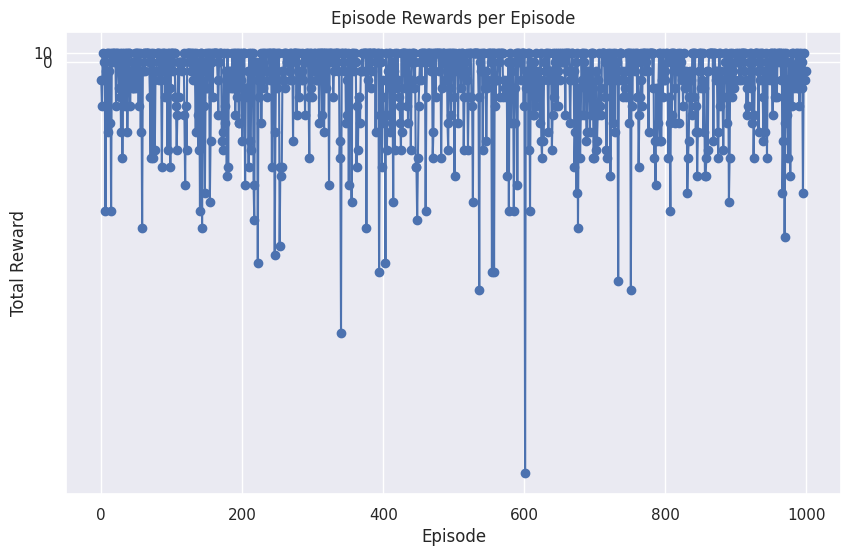

In [ ]:
import matplotlib.pyplot as plt

# Plotting the rewards per episode
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, marker='o', linestyle='-')
plt.title('Episode Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.yticks(range(0, max(episode_rewards) + 10, 10))
plt.grid(True)
plt.show()

In [ ]:

# Sort the collected performance values
total_reward = sorted(total_reward)

# Create a plot for all the performances
plt.figure(figsize=(8, 6))
plt.plot(total_reward)
plt.title("Reward for Different Hyperparameter Settings")
plt.xlabel("Index")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

TypeError: ignored

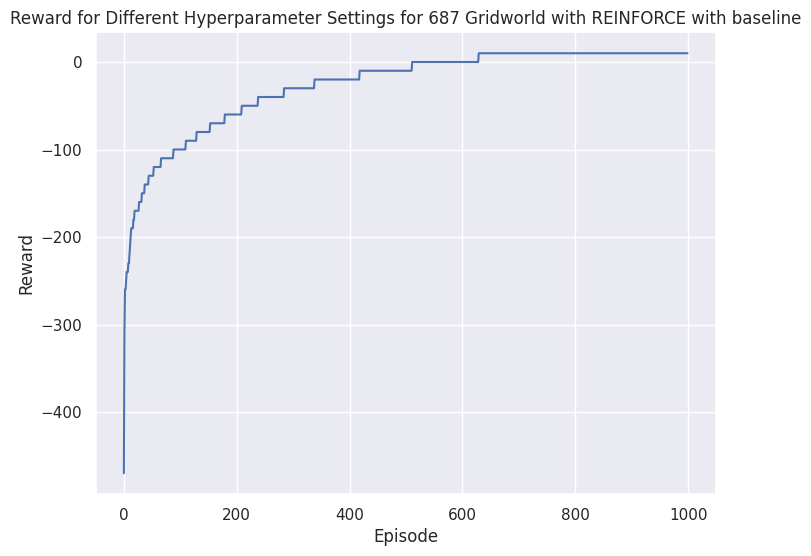

In [ ]:
# Sort the collected performance values
episode_rewards = sorted(episode_rewards)

# Create a plot for all the performances
plt.figure(figsize=(8, 6))
plt.plot(episode_rewards)
plt.title("Reward for Different Hyperparameter Settings for 687 Gridworld with REINFORCE with baseline")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

#Mountain Car

In [ ]:
basehash = hash

In [ ]:
from math import floor, log
from itertools import zip_longest

class IHT:
    def __init__(self, size):
        self.len1 = size
        self.full_count = 0
        self.dict1 = {}

    def __str__(self):
        return "Collision table:" + \
               f" length:{self.len1}" + \
               f" full_count:{self.full_count}" + \
               f" dictionary:{len(self.dict1)} items"

    def count_dict(self):
        return len(self.dict1)

    def fullp(self):
        return len(self.dict1) >= self.len1

    def getindex(self, obj, read=False):
        d = self.dict1
        if obj in d:
            return d[obj]
        elif read:
            return None
        len1 = self.len1
        count_dict = self.count_dict()
        if count_dict >= len1:
            if self.full_count == 0:
                print('Mountain car full, starting to allow collisions')
            self.full_count += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count_dict
            return count_dict


def hash_coordinates(path, m, read=False):
    if isinstance(m, IHT):
        return m.getindex(tuple(path), read)
    if isinstance(m, int):
        return basehash(tuple(path)) % m
    if m is None:
        return path


def tiles(hash_table_size, number_of_tilings, floats, integers=None, read=False):
    if integers is None:
        integers = []
    list_of_floats_q = [floor(f * number_of_tilings) for f in floats]
    list_of_Tiles = []
    for tiling in range(number_of_tilings):
        tiling_2 = tiling * 2
        hash_coords = [tiling]
        t = tiling
        for qs in list_of_floats_q:
            hash_coords.append((qs + t) // number_of_tilings)
            t += tiling_2
        hash_coords.extend(integers)
        list_of_Tiles.append(hash_coordinates(hash_coords, hash_table_size, read))
    return list_of_Tiles


def tiles_wrap(hash_table_size, number_of_tilings, floats, wrapwidths, integers=None, read=False):
    if integers is None:
        integers = []
    list_of_floats_q = [floor(f * number_of_tilings) for f in floats]
    list_of_Tiles = []
    for tiling in range(number_of_tilings):
        tilingX2 = tiling * 2
        hash_coordinates = [tiling]
        t1 = tiling
        for q, width in zip_longest(list_of_floats_q, wrapwidths):
            t2 = (q + t1 % number_of_tilings) // number_of_tilings
            hash_coordinates.append(t2 % width if width else t2)
            t1 += tilingX2
        hash_coordinates.extend(integers)
        list_of_Tiles.append(hash_coordinates(hash_coordinates, hash_table_size, read))
    return list_of_Tiles

In [ ]:
import numpy as np

class Tilecoder:
    def __init__(self, minimum_position, maximum_position, minimum_speed, maximum_speed,
                 hash_table_size=4096, number_of_tilings=8, number_of_tiles=4):
        self.hash_table_size = IHT(hash_table_size)
        self.number_of_tilings = number_of_tilings
        self.number_of_tiles = number_of_tiles
        self.minimum_speed = minimum_speed
        self.maximum_speed = maximum_speed
        self.minimum_position = minimum_position
        self.maximum_position = maximum_position

    def tiles(self, state):
        position, speed = state[0], state[1]
        position_scaled = (position - self.minimum_position) / (self.maximum_position - self.minimum_position) * self.number_of_tiles
        speed_scaled = (speed - self.minimum_speed) / (self.maximum_speed - self.minimum_speed) * self.number_of_tiles
        calculated_tiles = tiles(self.hash_table_size, self.number_of_tilings, [position_scaled, speed_scaled])
        return np.array(calculated_tiles)

In [ ]:
class ReinforceBaseLineAgent:
    def agent_init(self, agent_info = {}, adam_info = {}):
        minimum_position = agent_info.get('minimum_position')
        maximum_position = agent_info.get('maximum_position')
        minimum_speed = agent_info.get('minimum_speed')
        maximum_speed = agent_info.get('maximum_speed')
        self.hash_table_size = agent_info.get('hash_table_size')
        self.number_of_tilings = agent_info.get('number_of_tilings')
        self.number_of_tiles = agent_info.get('number_of_tiles')
        self.step_size_theta = agent_info.get('step_size_theta')
        self.step_size_w = agent_info.get('step_size_w')
        self.gamma = agent_info.get('gamma')
        self.number_of_actions = agent_info.get('number_of_actions')

        self.theta_0 = np.zeros((self.number_of_actions * self.hash_table_size, ))
        self.theta_0[0:self.hash_table_size] = 1
        self.theta_0[self.hash_table_size*2:] = 1

        self.weight = np.zeros((self.hash_table_size, ))

        self.tilecoder = Tilecoder(minimum_position, maximum_position, minimum_speed, maximum_speed,
        hash_table_size = self.hash_table_size, number_of_tilings = self.number_of_tilings, number_of_tiles = self.number_of_tiles)

    def agent_step(self, state):
        action = self.MDP_policy(state)
        return action

    def agent_end(reward):
        pass

    def state_feature(self, state):
        present_tile = self.tilecoder.tiles(state)
        if present_tile is not None:
            present_state_feature = np.zeros((self.hash_table_size, ))
            present_state_feature[present_tile] = 1
            return present_state_feature
        else:
            # Return a default or zero feature vector if present_tile is None
            return np.zeros((self.hash_table_size, ))


    def state_value(self, present_state_feature):
        print("state_value",self.weight,present_state_feature)
        state_value = np.dot(self.weight, present_state_feature)
        return state_value

    def state_action(self, state, action):
        present_tile = self.tilecoder.tiles(state)
        present_feature_per_action = np.zeros((self.hash_table_size, ))
        present_feature_per_action[present_tile] = 1
        present_state_action_feature = np.zeros((self.number_of_actions * self.hash_table_size, ))
        present_state_action_feature[self.hash_table_size * action:self.hash_table_size * (action+1)] = present_feature_per_action
        return present_state_action_feature

    def value_of_action(self, present_state_action_feature):
        value_of_action = np.dot(self.theta_0, present_state_action_feature)
        return value_of_action

    def softmax(self, state):
        list_of_preferences = []
        for a in range(self.number_of_actions):
            present_state_action_feature = self.state_action(state, a)
            value_of_action = self.value_of_action(present_state_action_feature)
            list_of_preferences.append(value_of_action)
        list_of_preferences = np.array(list_of_preferences)
        max_preferences = np.max(list_of_preferences)
        list_of_preferences = list_of_preferences - max_preferences
        exponential_preferences = np.exp(list_of_preferences)
        exponential_preferences_sum  = np.sum(exponential_preferences)
        probablity_of_action = exponential_preferences / exponential_preferences_sum
        return probablity_of_action

    def MDP_policy(self, state):
        probablity_of_action = self.softmax(state)
        action = np.random.choice(self.number_of_actions, p=probablity_of_action)
        return action

    def gradient(self, state, action):
        present_state_action_feature = self.state_action(state, action)
        probablity_of_action = self.softmax(state)

        set_of_feature = []
        for a in range(self.number_of_actions):
            feature = self.state_action(state, a)
            set_of_feature.append(feature)
        set_of_feature = np.array(set_of_feature)
        expected_feature_value = np.dot(probablity_of_action, set_of_feature)


        gradient = present_state_action_feature - expected_feature_value
        return gradient

    def theta_weight_updation(self, action, state, delta, t):
        gradient = self.gradient(state, action)
        self.theta_0 = self.theta_0 + self.step_size_theta * (self.gamma ** t) * delta * gradient

    def w_weight_updation(self, state, delta):
        self.weight = self.weight + self.step_size_w * delta * self.state_feature(state)

In [ ]:
import numpy as np
import gym

# Initialize environment
max_steps = 2000
gym.envs.register(
    id='MountainCarMyEasyVersion-v0',
    entry_point='gym.envs.classic_control:MountainCarEnv',
    max_episode_steps=200,  # MountainCar-v0 uses 200
)
env = gym.make('MountainCarMyEasyVersion-v0')
minimum_position, minimum_speed = env.observation_space.low
maximum_position, maximum_speed = env.observation_space.high


# Initialize REINFORCE Baseline agent
step_size_theta = 2e-8
number_of_tilings = 16
step_size_w = 0.1 / number_of_tilings
agent_info = {'minimum_position': minimum_position, 'minimum_speed':minimum_speed,
            'maximum_position': maximum_position, 'maximum_speed': maximum_speed,
            'number_of_actions': env.action_space.n, 'hash_table_size': 4096,
            'number_of_tilings': number_of_tilings, 'number_of_tiles': 8,
            'step_size_theta': step_size_theta, 'step_size_w': step_size_w,
            'gamma': 1}

agent = ReinforceBaseLineAgent()
agent.agent_init(agent_info)

# Episodes rollout
num_episode = 1000  # Adjust this value for tuning

list_of_episode_rewards = []
list_of_average_rewards = []

for episode in range(num_episode):

    # Generate episodes
    list_of_states = []
    list_of_action = []
    list_of_reward = []
    state = env.reset()

    total_reward = 0
    terminate = False
    while not terminate:
        action = agent.agent_step(state)
        list_of_states.append(state)
        list_of_action.append(action)
        state, reward, terminate, info = env.step(action)
        total_reward += reward
        if terminate:
            break
        list_of_reward.append(reward)

    if total_reward == 500:
        break
    else:
        for t in range(len(list_of_reward)):
            Reward = 0
            power_arr = np.arange(t + 1, len(list_of_states))
            agent_discount_factor_arr = np.array([agent.gamma] * len(power_arr))
            reward_arr = np.array(list_of_reward[t:len(list_of_states)])
            Reward = np.power(agent_discount_factor_arr, power_arr)
            Reward = np.dot(Reward, reward_arr)

            state = list_of_states[t]
            action = list_of_action[t]
            present_state_feature = agent.state_feature(state)
            delta = Reward - agent.state_value(present_state_feature)
            agent.w_weight_updation(state, delta)
            agent.theta_weight_updation(action, state, delta, t)

        list_of_episode_rewards.append(total_reward)
        if episode > 100:
            average_reward = np.mean(list_of_episode_rewards[episode - 100: episode])
            list_of_average_rewards.append(average_reward)
        else:
            list_of_average_rewards.append(np.mean(list_of_episode_rewards))
    print(f'Episode: {episode + 1}, Total Reward: {total_reward}')

# Print the total reward after each episode
for episode, reward in enumerate(list_of_average_rewards):
    print(f'Episode {episode + 1}: Total Reward: {reward}')


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment MountainCarMyEasyVersion-v0
  logger.warn(f"Overriding environment {spec.id}")
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode: 1, Total Reward: -200.0
Episode: 2, Total Reward: -200.0
Episode: 3, Total Reward: -200.0
Episode: 4, Total Reward: -200.0
Episode: 5, Total Reward: -200.0
Episode: 6, Total Reward: -200.0
Episode: 7, Total Reward: -200.0
Episode: 8, Total Reward: -200.0
Episode: 9, Total Reward: -200.0
Episode: 10, Total Reward: -200.0
Episode: 11, Total Reward: -200.0
Episode: 12, Total Reward: -200.0
Episode: 13, Total Reward: -200.0
Episode: 14, Total Reward: -200.0
Episode: 15, Total Reward: -200.0
Episode: 16, Total Reward: -200.0
Episode: 17, Total Reward: -200.0
Episode: 18, Total Reward: -200.0
Episode: 19, Total Reward: -200.0
Episode: 20, Total Reward: -200.0
Episode: 21, Total Reward: -200.0
Episode: 22, Total Reward: -200.0
Episode: 23, Total Reward: -200.0
Episode: 24, Total Reward: -200.0
Episode: 25, Total Reward: -200.0
Episode: 26, Total Reward: -200.0
Episode: 27, Total Reward: -200.0
Episode: 28, Total Reward: -200.0
Episode: 29, Total Reward: -200.0
Episode: 30, Total Rewa

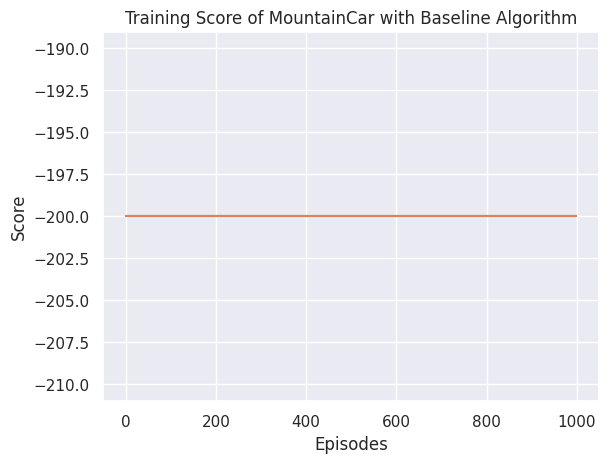

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

if len(list_of_episode_rewards) == 0:
    print("Error: episode_rewards is empty.")
else:
    # Plot the rewards
    plt.plot(list_of_episode_rewards)
    plt.ylabel('Score')
    plt.xlabel('Episodes')
    plt.title('Training Score of MountainCar with Baseline Algorithm')

    # Reshaping rewards_list for linear regression
    X = np.arange(len(list_of_episode_rewards)).reshape(-1, 1)
    y = np.array(list_of_episode_rewards).reshape(-1, 1)

    # Performing linear regression
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)

    # Plotting the linear regression line
    plt.plot(y_pred)
    plt.show()


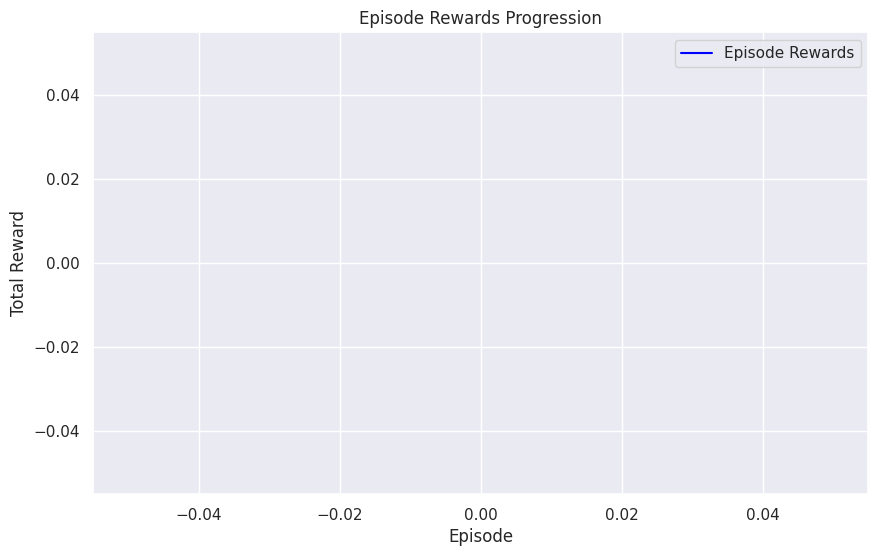

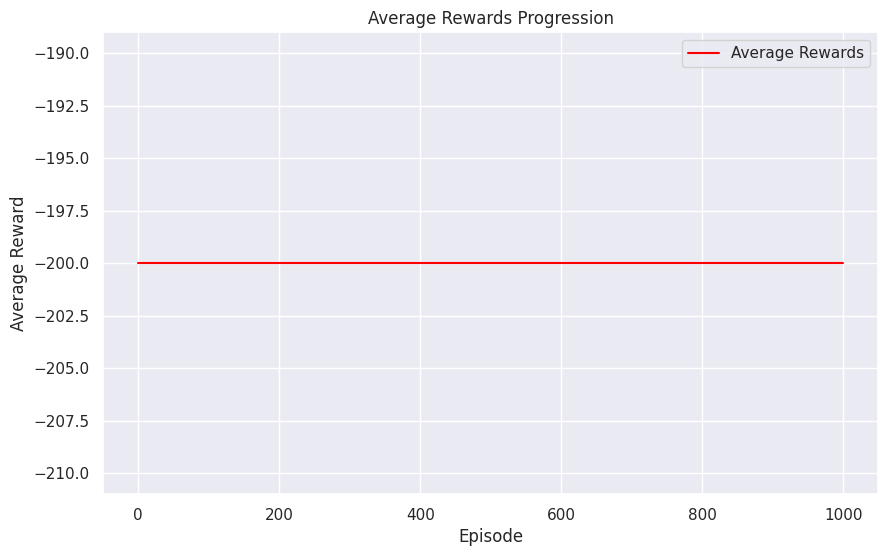

In [ ]:
import matplotlib.pyplot as plt

# Plotting the episode rewards
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label='Episode Rewards', color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Episode Rewards Progression')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the average rewards
plt.figure(figsize=(10, 6))
plt.plot(list_of_average_rewards, label='Average Rewards', color='red')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Rewards Progression')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
class ReinforceBaseLineAgent:
    def agent_init(self, agent_info = {}, adam_info = {}):
        minimum_position = agent_info.get('minimum_position')
        maximum_position = agent_info.get('maximum_position')
        # print("maximum_position_agent",maximum_position)
        minimum_speed = agent_info.get('minimum_speed')
        maximum_speed = agent_info.get('maximum_speed')
        self.hash_table_size = agent_info.get('hash_table_size')
        self.number_of_tilings = agent_info.get('number_of_tilings')
        self.number_of_tiles = agent_info.get('number_of_tiles')
        self.step_size_theta = agent_info.get('step_size_theta')
        self.step_size_w = agent_info.get('step_size_w')
        self.gamma = agent_info.get('gamma')
        self.number_of_actions = agent_info.get('number_of_actions')

        self.theta_0 = np.zeros((self.number_of_actions * self.hash_table_size, ))
        self.theta_0[0:self.hash_table_size] = 1
        self.theta_0[self.hash_table_size*2:] = 1

        self.weight = np.zeros((self.hash_table_size, ))

        self.tilecoder = Tilecoder(minimum_position, maximum_position, minimum_speed, maximum_speed,
        hash_table_size = self.hash_table_size, number_of_tilings = self.number_of_tilings, number_of_tiles = self.number_of_tiles)

    def agent_step(self, state):
        action = self.MDP_policy(state)
        return action

    def agent_end(reward):
        pass

    def state_feature(self, state):
        present_tile = self.tilecoder.tiles(state)
        if present_tile is not None:
            present_state_feature = np.zeros((self.hash_table_size, ))
            present_state_feature[present_tile] = 1
            return present_state_feature
        else:
            # Return a default or zero feature vector if present_tile is None
            return np.zeros((self.hash_table_size, ))


    def state_value(self, present_state_feature):
        state_value = np.dot(self.weight, present_state_feature)
        return state_value

    def state_action(self, state, action):
        present_tile = self.tilecoder.tiles(state)
        present_feature_per_action = np.zeros((self.hash_table_size, ))
        present_feature_per_action[present_tile] = 1
        present_state_action_feature = np.zeros((self.number_of_actions * self.hash_table_size, ))
        present_state_action_feature[self.hash_table_size * action:self.hash_table_size * (action+1)] = present_feature_per_action
        return present_state_action_feature

    def value_of_action(self, present_state_action_feature):
        value_of_action = np.dot(self.theta_0, present_state_action_feature)
        return value_of_action

    def softmax(self, state):
        list_of_preferences = []
        for a in range(self.number_of_actions):
            present_state_action_feature = self.state_action(state, a)
            value_of_action = self.value_of_action(present_state_action_feature)
            list_of_preferences.append(value_of_action)

        list_of_preferences = np.array(list_of_preferences)
        max_preferences = np.max(list_of_preferences)
        list_of_preferences = list_of_preferences - max_preferences

        # Apply softmax only if there are valid preferences
        if not np.isnan(np.sum(list_of_preferences)):
            exponential_preferences = np.exp(list_of_preferences)
            exponential_preferences_sum = np.sum(exponential_preferences)

            # Check if the sum is not zero to avoid division by zero
            if exponential_preferences_sum != 0:
                probablity_of_action = exponential_preferences / exponential_preferences_sum
                return probablity_of_action
            else:
                # Return equal probabilities if the sum is zero
                return np.ones_like(list_of_preferences) / len(list_of_preferences)
        else:
            # Return equal probabilities if NaN values are encountered
            return np.ones_like(list_of_preferences) / len(list_of_preferences)


    def MDP_policy(self, state):
        probablity_of_action = self.softmax(state)
        action = np.random.choice(self.number_of_actions, p=probablity_of_action)
        return action

    def gradient(self, state, action):
        present_state_action_feature = self.state_action(state, action)
        probablity_of_action = self.softmax(state)

        set_of_feature = []
        for a in range(self.number_of_actions):
            feature = self.state_action(state, a)
            set_of_feature.append(feature)
        set_of_feature = np.array(set_of_feature)
        expected_feature_value = np.dot(probablity_of_action, set_of_feature)


        gradient = present_state_action_feature - expected_feature_value
        return gradient

    def theta_weight_updation(self, action, state, delta, t):
        gradient = self.gradient(state, action)
        delta_adjusted = np.zeros_like(self.theta_0)
        delta_adjusted[:] = delta  # Set the entire delta_adjusted array to the single delta value

        self.theta_0 = self.theta_0 + self.step_size_theta * (self.gamma ** t) * delta_adjusted * gradient



    def w_weight_updation(self, state, delta):
        present_state_feature = self.state_feature(state)

        # Ensure delta is of the same shape as present_state_feature
        delta_adjusted = np.zeros_like(present_state_feature)
        delta_adjusted[:len(delta)] = delta  # Adjust delta to match the shape of present_state_feature

        self.weight = self.weight + self.step_size_w * delta_adjusted * present_state_feature

In [ ]:
import numpy as np
import gym


if __name__ == "__main__":
    # Initialize environment
    max_steps = 200
    gym.envs.register(
        id='MountainCarMyEasyVersion-v0',
        entry_point='gym.envs.classic_control:MountainCarEnv',
        max_episode_steps=max_steps,  # MountainCar-v0 uses 200
    )
    env = gym.make('MountainCarMyEasyVersion-v0')
    minimum_position, minimum_speed = env.observation_space.low
    maximum_position, maximum_speed = env.observation_space.high

    # Define hyperparameters for tuning
    step_sizes_thetas = [0.001, 0.01, 0.1]
    num_of_tilings_values = [4, 8, 16]
    step_size_omegas = [0.05, 0.1, 0.2]

    best_average_reward = float("-inf")
    best_hyperparams = None
    hyperparameter_results = []
    # Perform grid search for hyperparameters
    for step_size_theta in step_sizes_thetas:
        for number_of_tilings in num_of_tilings_values:
            for step_size_omega in step_size_omegas:
                agent_info = {
                  'minimum_position': minimum_position, 'minimum_speed': minimum_speed,
                  'maximum_position': maximum_position, 'maximum_speed': maximum_speed,
                  'number_of_actions': env.action_space.n, 'hash_table_size': 4096,
                  'number_of_tilings': number_of_tilings, 'number_of_tiles': 8,
                  'step_size_w': step_size_omega, 'gamma': 1,'step_size_theta':step_size_theta
                }

                agent = ReinforceBaseLineAgent()
                agent.agent_init(agent_info)

                # Episodes rollout for a fixed number
                num_episode = 500

                episode_rewards = []
                average_rewards = []

                for episode in range(num_episode):
                    print(f'Hyperparameters: theta={step_size_theta}, tilings={number_of_tilings}, w={step_size_omega}, Episode: {episode + 1}')

                    # Generate episodes
                    list_of_states = []
                    list_of_action = []
                    list_of_reward = []
                    episode_deltas = []
                    state = env.reset()

                    total_reward = 0
                    terminal = False
                    while not terminal:
                        action = agent.agent_step(state)
                        list_of_states.append(state)
                        list_of_action.append(action)
                        state, reward, terminal, info = env.step(action)
                        total_reward += reward
                        if terminal:
                            break
                        list_of_reward.append(reward)

                    if total_reward == -50:
                        break
                    else:
                        for t in range(len(list_of_reward)):
                            g = 0
                            list_of_power = np.arange(t + 1, len(list_of_states))
                            agent_gamma_arr = np.array([agent.gamma] * len(list_of_power))
                            reward_arr = np.array(list_of_reward[t:])
                            g = np.power(agent_gamma_arr, list_of_power)
                            g = np.dot(g, reward_arr)

                            state = list_of_states[t]
                            action = list_of_action[t]
                            present_state_feature = agent.state_feature(state)
                            delta = g - agent.state_value(present_state_feature)
                            episode_deltas.append(delta)
                            agent.w_weight_updation(state, episode_deltas)
                            agent.theta_weight_updation(action, state, delta, t)

                        episode_rewards.append(total_reward)
                        if episode > 100:
                            average_reward = np.mean(episode_rewards[episode - 100: episode])
                            average_rewards.append(average_reward)
                        else:
                            average_rewards.append(np.mean(episode_rewards))

                # Calculate average reward
                average_reward = np.mean(episode_rewards[-100:])  # Last 100 episodes


                # Store the results or metrics of interest
                hyperparameter_results.append({
                    'step_size_theta': step_size_theta,
                    'step_size_omega': step_size_omega,
                    'max_steps': max_steps,
                    'number_of_tilings': number_of_tilings,
                    'reward': reward,
                    'total_reward': total_reward
                    # Store scores or any other relevant metrics
                })


                # Update best hyperparameters if this combination is better
                if average_reward > best_average_reward:
                    best_average_reward = average_reward
                    best_hyperparams = {
                        'step_size_theta': step_size_theta,
                        'number_of_tilings': number_of_tilings,
                        'step_size_w': step_size_omega,
                        'step_size_theta':step_size_theta
                    }
                print(f'Episode: {episode + 1}, Total Reward: {total_reward}')

    # After grid search, best_hyperparams will contain the best set of hyperparameters
    print("Best Hyperparameters:", best_hyperparams)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment MountainCarMyEasyVersion-v0
  logger.warn(f"Overriding environment {spec.id}")
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 1
Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 2
Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 3
Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 4
Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 5
Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 6
Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 7
Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 8
Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 9
Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 10
Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 11
Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 12
Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 13
Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 14
Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 15
Hyperparameters: theta=0.001, tilings=4, w=0.05, Episode: 16
Hyperparameters: theta=0.001, til

<ipython-input-9-3b575078b099>:123: RuntimeWarning: invalid value encountered in multiply
  self.weight = self.weight + self.step_size_w * delta_adjusted * present_state_feature
<ipython-input-9-3b575078b099>:112: RuntimeWarning: invalid value encountered in multiply
  self.theta_0 = self.theta_0 + self.step_size_theta * (self.gamma ** t) * delta_adjusted * gradient
<ipython-input-9-3b575078b099>:123: RuntimeWarning: overflow encountered in add
  self.weight = self.weight + self.step_size_w * delta_adjusted * present_state_feature


Streaming output truncated to the last 5000 lines.
Hyperparameters: theta=0.01, tilings=16, w=0.2, Episode: 12
Hyperparameters: theta=0.01, tilings=16, w=0.2, Episode: 13
Hyperparameters: theta=0.01, tilings=16, w=0.2, Episode: 14
Hyperparameters: theta=0.01, tilings=16, w=0.2, Episode: 15
Hyperparameters: theta=0.01, tilings=16, w=0.2, Episode: 16
Hyperparameters: theta=0.01, tilings=16, w=0.2, Episode: 17
Hyperparameters: theta=0.01, tilings=16, w=0.2, Episode: 18
Hyperparameters: theta=0.01, tilings=16, w=0.2, Episode: 19
Hyperparameters: theta=0.01, tilings=16, w=0.2, Episode: 20
Hyperparameters: theta=0.01, tilings=16, w=0.2, Episode: 21
Hyperparameters: theta=0.01, tilings=16, w=0.2, Episode: 22
Hyperparameters: theta=0.01, tilings=16, w=0.2, Episode: 23
Hyperparameters: theta=0.01, tilings=16, w=0.2, Episode: 24
Hyperparameters: theta=0.01, tilings=16, w=0.2, Episode: 25
Hyperparameters: theta=0.01, tilings=16, w=0.2, Episode: 26
Hyperparameters: theta=0.01, tilings=16, w=0.2, E

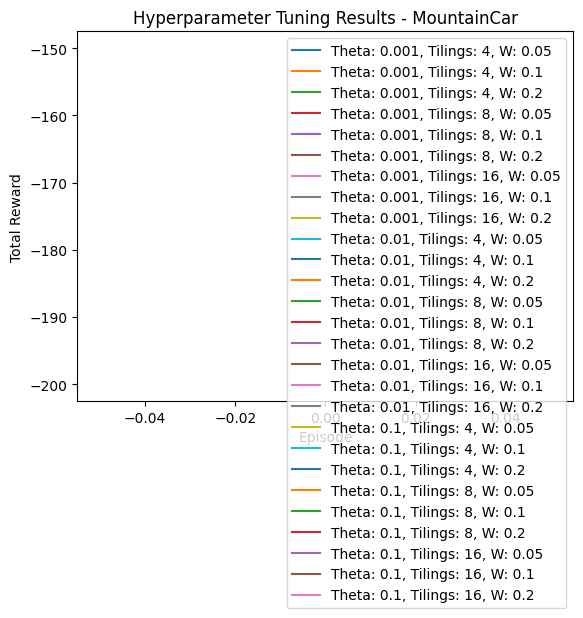

In [ ]:
# Initialize plot outside the loop
plt.figure()

# Dictionary to hold rewards per hyperparameter combination
rewards_dict = {}

# Accumulate rewards per hyperparameter combination
for result in hyperparameter_results:
    step_size_theta = result['step_size_theta']
    number_of_tilings = result['number_of_tilings']
    step_size_w = result['step_size_omega']
    total_reward = result['total_reward']

    label = f'Theta: {step_size_theta}, Tilings: {number_of_tilings}, W: {step_size_w}'
    if label not in rewards_dict:
        rewards_dict[label] = []
    rewards_dict[label].append(total_reward)

# Plotting the results for each hyperparameter combination
for label, rewards in rewards_dict.items():
    plt.plot(rewards, label=label)

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Hyperparameter Tuning Results - MountainCar')
plt.legend()  # Show legend with labels
plt.show()

In [ ]:
print

In [ ]:
import matplotlib.pyplot as plt

# Assume hyperparameter_results is a list of dictionaries with 'episode_rewards' key containing episode-wise rewards

# Plotting the results
for result in hyperparameter_results:
    step_size_theta = result['step_size_theta']
    num_tilings = result['number_of_tilings']
    step_size_w = result['step_size_omega']
    episode_rewards = result['reward']

    label = f'Theta: {step_size_theta}, Tilings: {num_tilings}, W: {step_size_w}'
    plt.plot(episode_rewards, label=label)

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Hyperparameter Tuning Results - MountainCar')
plt.legend()
plt.show()


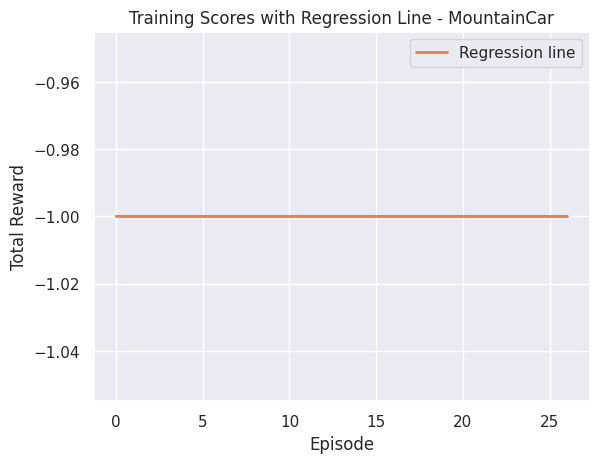

In [ ]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
# Store all episode scores in a single list
all_scores = []
for result in hyperparameter_results:
    reward = result['reward']
    if isinstance(reward, list):  # Check if 'reward' is a list
        all_scores.append(reward)  # If it's a list, append it directly to all_scores
    else:
        all_scores.append([reward])  # If it's a float, append it as a single-element list to all_scores

# Flatten the list of lists into a single list
all_scores = [score for sublist in all_scores for score in sublist]

# Plotting the results
sns.set()
plt.plot(all_scores, alpha=0.5)  # Plot all scores with transparency

# Fit a regression line to the combined scores
reg = LinearRegression().fit(np.arange(len(all_scores)).reshape(-1, 1), np.array(all_scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(all_scores)).reshape(-1, 1))
plt.plot(y_pred, label=f'Regression line', linewidth=2)

plt.ylabel('Total Reward')
plt.xlabel('Episode')
plt.title('Training Scores with Regression Line - MountainCar')
plt.legend()
plt.show()

In [ ]:
print(hyperparameter_results)

[{'step_size_theta': 0.001, 'step_size_omega': 0.05, 'max_steps': 200, 'number_of_tilings': 4, 'reward': -1.0, 'total_reward': -200.0}, {'step_size_theta': 0.001, 'step_size_omega': 0.1, 'max_steps': 200, 'number_of_tilings': 4, 'reward': -1.0, 'total_reward': -200.0}, {'step_size_theta': 0.001, 'step_size_omega': 0.2, 'max_steps': 200, 'number_of_tilings': 4, 'reward': -1.0, 'total_reward': -200.0}, {'step_size_theta': 0.001, 'step_size_omega': 0.05, 'max_steps': 200, 'number_of_tilings': 8, 'reward': -1.0, 'total_reward': -200.0}, {'step_size_theta': 0.001, 'step_size_omega': 0.1, 'max_steps': 200, 'number_of_tilings': 8, 'reward': -1.0, 'total_reward': -200.0}, {'step_size_theta': 0.001, 'step_size_omega': 0.2, 'max_steps': 200, 'number_of_tilings': 8, 'reward': -1.0, 'total_reward': -200.0}, {'step_size_theta': 0.001, 'step_size_omega': 0.05, 'max_steps': 200, 'number_of_tilings': 16, 'reward': -1.0, 'total_reward': -161.0}, {'step_size_theta': 0.001, 'step_size_omega': 0.1, 'max_s